<a href="https://colab.research.google.com/github/auth-create/DDfiles/blob/main/engenharia_reversa_videos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ============================================================================
# SISTEMA MODULAR DE ENGENHARIA REVERSA - GOOGLE COLAB
# Cada célula = Um processo independente com validação de pré-requisitos
# ============================================================================

# ============================================================================
# CÉLULA 1: SETUP INICIAL E DEPENDÊNCIAS
# ============================================================================

# Instalar dependências necessárias
!pip install -q moviepy librosa pytesseract opencv-python pandas openpyxl matplotlib seaborn pillow
!apt-get update -qq && apt-get install -y -qq tesseract-ocr tesseract-ocr-por ffmpeg

# Imports necessários
import os
import json
import pandas as pd
from datetime import datetime
import logging
import cv2
import numpy as np
import pytesseract
import librosa
from moviepy.editor import VideoFileClip
import matplotlib.pyplot as plt
from PIL import Image
from collections import Counter
import seaborn as sns
from google.colab import drive
import warnings
warnings.filterwarnings('ignore')

# Montar Google Drive
drive.mount('/content/drive')

print("✅ SETUP CONCLUÍDO")
print("Dependências instaladas e Google Drive montado.")
print("Próximo passo: Execute a CÉLULA 2 - CONFIGURAÇÃO INICIAL")

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Selecting previously unselected package tesseract-ocr-por.
(Reading database ... 126371 files and directories currently installed.)
Preparing to unpack .../tesseract-ocr-por_1%3a4.00~git30-7274cfa-1.1_all.deb ...
Unpacking tesseract-ocr-por (1:4.00~git30-7274cfa-1.1) ...
Setting up tesseract-ocr-por (1:4.00~git30-7274cfa-1.1) ...


/usr/local/lib/python3.12/dist-packages/moviepy/config_defaults.py:47: SyntaxWarning: invalid escape sequence '\P'
  IMAGEMAGICK_BINARY = r"C:\Program Files\ImageMagick-6.8.8-Q16\magick.exe"
/usr/local/lib/python3.12/dist-packages/moviepy/video/io/ffmpeg_reader.py:294: SyntaxWarning: invalid escape sequence '\d'
  lines_video = [l for l in lines if ' Video: ' in l and re.search('\d+x\d+', l)]
/usr/local/lib/python3.12/dist-packages/moviepy/video/io/ffmpeg_reader.py:367: SyntaxWarning: invalid escape sequence '\d'
  rotation_lines = [l for l in lines if 'rotate          :' in l and re.search('\d+$', l)]
/usr/local/lib/python3.12/dist-packages/moviepy/video/io/ffmpeg_reader.py:370: SyntaxWarning: invalid escape sequence '\d'
  match = re.search('\d+$', rotation_line)
  if event.key is 'enter':



Mounted at /content/drive
✅ SETUP CONCLUÍDO
Dependências instaladas e Google Drive montado.
Próximo passo: Execute a CÉLULA 2 - CONFIGURAÇÃO INICIAL


In [ ]:
# CÉLULA 2: CONFIGURAÇÃO INICIAL E VALIDAÇÃO DA PASTA
# ============================================================================

# CONFIGURE SEU CAMINHO AQUI
CAMINHO_PASTA_VIDEOS = "/content/drive/MyDrive/Videos Dona Done"

# Classe para gerenciar configuração inicial
class ConfiguradorProjeto:
    def __init__(self, caminho_pasta):
        self.pasta_videos = self._validar_caminho(caminho_pasta)
        self.pasta_trabalho = os.path.join(self.pasta_videos, "_engenharia_reversa")
        self._criar_estrutura()
        self._configurar_logging()

    def _validar_caminho(self, caminho):
        if caminho == "/content/drive/MyDrive/SUBSTITUA_PELO_SEU_CAMINHO":
            raise ValueError("❌ ERRO: Você precisa alterar CAMINHO_PASTA_VIDEOS com o caminho real da sua pasta")

        if not os.path.exists(caminho):
            raise ValueError(f"❌ ERRO: Pasta não encontrada: {caminho}")

        return caminho

    def _criar_estrutura(self):
        estrutura = [
            'config', 'logs', 'dados', 'frames_extraidos',
            'analise_texto', 'analise_audio', 'capturas',
            'relatorios', 'blueprint', 'temp'
        ]

        os.makedirs(self.pasta_trabalho, exist_ok=True)
        for pasta in estrutura:
            os.makedirs(os.path.join(self.pasta_trabalho, pasta), exist_ok=True)

    def _configurar_logging(self):
        log_file = os.path.join(self.pasta_trabalho, "logs", f"sistema_{datetime.now().strftime('%Y%m%d_%H%M%S')}.log")
        logging.basicConfig(
            level=logging.INFO,
            format='%(asctime)s - %(levelname)s - %(message)s',
            handlers=[logging.FileHandler(log_file, encoding='utf-8')]
        )
        self.logger = logging.getLogger(__name__)

    def salvar_configuracao(self):
        config = {
            "projeto": {
                "pasta_videos": self.pasta_videos,
                "pasta_trabalho": self.pasta_trabalho,
                "criado_em": datetime.now().isoformat(),
                "versao": "modular_v1.0"
            },
            "status_etapas": {
                "configuracao": True,
                "descoberta_videos": False,
                "metadados": False,
                "decomposicao": False,
                "analise_padroes": False,
                "blueprint": False
            }
        }

        config_path = os.path.join(self.pasta_trabalho, "config", "config.json")
        with open(config_path, 'w', encoding='utf-8') as f:
            json.dump(config, f, indent=2, ensure_ascii=False)

        return config_path

# Executar configuração
try:
    configurador = ConfiguradorProjeto(CAMINHO_PASTA_VIDEOS)
    config_path = configurador.salvar_configuracao()

    print("✅ CONFIGURAÇÃO CONCLUÍDA")
    print(f"Pasta de trabalho criada: {configurador.pasta_trabalho}")
    print(f"Configuração salva: {config_path}")
    print("Próximo passo: Execute a CÉLULA 3 - DESCOBERTA DE VÍDEOS")

    # Salvar variáveis globais para próximas células
    PASTA_VIDEOS = configurador.pasta_videos
    PASTA_TRABALHO = configurador.pasta_trabalho

except Exception as e:
    print(f"❌ ERRO NA CONFIGURAÇÃO: {e}")
    print("Corrija o erro antes de prosseguir.")

✅ CONFIGURAÇÃO CONCLUÍDA
Pasta de trabalho criada: /content/drive/MyDrive/Videos Dona Done/_engenharia_reversa
Configuração salva: /content/drive/MyDrive/Videos Dona Done/_engenharia_reversa/config/config.json
Próximo passo: Execute a CÉLULA 3 - DESCOBERTA DE VÍDEOS


In [ ]:
# CÉLULA 3: DESCOBERTA E CATALOGAÇÃO DE VÍDEOS
# ============================================================================

def verificar_prerequisito_etapa2():
    """Verifica se a configuração foi executada com sucesso"""
    try:
        if not 'PASTA_TRABALHO' in globals():
            raise Exception("Execute a CÉLULA 2 primeiro")

        config_path = os.path.join(PASTA_TRABALHO, "config", "config.json")
        if not os.path.exists(config_path):
            raise Exception("Configuração não encontrada. Execute a CÉLULA 2 primeiro")

        return True
    except Exception as e:
        print(f"❌ PRÉ-REQUISITO NÃO ATENDIDO: {e}")
        return False

def descobrir_catalogar_videos():
    """Descobre e cataloga todos os vídeos na pasta"""
    formatos_aceitos = ['.mp4', '.mov', '.avi', '.mkv', '.webm', '.m4v']
    videos_encontrados = []

    print("Descobrindo vídeos...")

    for root, dirs, files in os.walk(PASTA_VIDEOS):
        if "_engenharia_reversa" in root:
            continue

        for file in files:
            if any(file.lower().endswith(fmt) for fmt in formatos_aceitos):
                video_path = os.path.join(root, file)

                try:
                    stat_info = os.stat(video_path)
                    video_id = f"vid_{len(videos_encontrados)+1:03d}"

                    video_info = {
                        'id': video_id,
                        'nome_arquivo': file,
                        'caminho_completo': video_path,
                        'caminho_relativo': os.path.relpath(video_path, PASTA_VIDEOS),
                        'tamanho_mb': round(stat_info.st_size / (1024*1024), 2),
                        'data_modificacao': datetime.fromtimestamp(stat_info.st_mtime).isoformat(),
                        'extensao': os.path.splitext(file)[1].lower(),
                        'status': 'descoberto'
                    }

                    videos_encontrados.append(video_info)

                except Exception as e:
                    continue

    return videos_encontrados

def salvar_lista_videos(videos):
    """Salva lista de vídeos encontrados"""
    videos_path = os.path.join(PASTA_TRABALHO, "dados", "videos_descobertos.json")
    with open(videos_path, 'w', encoding='utf-8') as f:
        json.dump(videos, f, indent=2, ensure_ascii=False)

    # Atualizar status no config
    config_path = os.path.join(PASTA_TRABALHO, "config", "config.json")
    with open(config_path, 'r', encoding='utf-8') as f:
        config = json.load(f)

    config['status_etapas']['descoberta_videos'] = True
    config['total_videos_encontrados'] = len(videos)

    with open(config_path, 'w', encoding='utf-8') as f:
        json.dump(config, f, indent=2, ensure_ascii=False)

    return videos_path

# Executar descoberta
if verificar_prerequisito_etapa2():
    try:
        videos_encontrados = descobrir_catalogar_videos()

        if not videos_encontrados:
            print("❌ NENHUM VÍDEO ENCONTRADO")
            print(f"Verifique se há vídeos na pasta: {PASTA_VIDEOS}")
        else:
            videos_path = salvar_lista_videos(videos_encontrados)

            print("✅ DESCOBERTA DE VÍDEOS CONCLUÍDA")
            print(f"Vídeos encontrados: {len(videos_encontrados)}")
            print(f"Lista salva em: {videos_path}")

            # Mostrar resumo
            extensoes = Counter([v['extensao'] for v in videos_encontrados])
            print(f"Formatos encontrados: {dict(extensoes)}")
            print("Próximo passo: Execute a CÉLULA 4 - EXTRAÇÃO DE METADADOS")

    except Exception as e:
        print(f"❌ ERRO NA DESCOBERTA: {e}")

Descobrindo vídeos...
✅ DESCOBERTA DE VÍDEOS CONCLUÍDA
Vídeos encontrados: 40
Lista salva em: /content/drive/MyDrive/Videos Dona Done/_engenharia_reversa/dados/videos_descobertos.json
Formatos encontrados: {'.mp4': 40}
Próximo passo: Execute a CÉLULA 4 - EXTRAÇÃO DE METADADOS


In [ ]:
# CÉLULA 4: EXTRAÇÃO DE METADADOS DOS VÍDEOS
# ============================================================================

def verificar_prerequisito_etapa3():
    """Verifica se a descoberta foi executada com sucesso"""
    try:
        config_path = os.path.join(PASTA_TRABALHO, "config", "config.json")
        with open(config_path, 'r', encoding='utf-8') as f:
            config = json.load(f)

        if not config['status_etapas']['descoberta_videos']:
            raise Exception("Execute a CÉLULA 3 primeiro")

        videos_path = os.path.join(PASTA_TRABALHO, "dados", "videos_descobertos.json")
        if not os.path.exists(videos_path):
            raise Exception("Lista de vídeos não encontrada. Execute a CÉLULA 3 primeiro")

        return True, videos_path
    except Exception as e:
        print(f"❌ PRÉ-REQUISITO NÃO ATENDIDO: {e}")
        return False, None

def extrair_metadados_video(video_info):
    """Extrai metadados técnicos de um vídeo"""
    video_path = video_info['caminho_completo']
    video_id = video_info['id']

    # Análise com OpenCV
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise Exception("Não foi possível abrir o vídeo")

    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    largura = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    altura = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    duracao = frame_count / fps if fps > 0 else 0

    # Capturar primeiro frame
    ret, primeiro_frame = cap.read()
    cap.release()

    # Análise de áudio
    try:
        clip = VideoFileClip(video_path)
        tem_audio = clip.audio is not None
        clip.close()
    except:
        tem_audio = False

    # Análise do primeiro frame
    analise_frame = {}
    if ret:
        # Salvar primeiro frame
        capturas_dir = os.path.join(PASTA_TRABALHO, "capturas")
        frame_path = os.path.join(capturas_dir, f"{video_id}_primeiro_frame.jpg")
        cv2.imwrite(frame_path, primeiro_frame)

        # Análises do frame
        gray = cv2.cvtColor(primeiro_frame, cv2.COLOR_BGR2GRAY)
        complexidade = cv2.Laplacian(gray, cv2.CV_64F).var()
        brilho = np.mean(gray)

        analise_frame = {
            'path': frame_path,
            'complexidade_visual': float(complexidade),
            'brilho_medio': float(brilho),
            'tem_muito_texto': bool(complexidade > 500),
            'e_escuro': bool(brilho < 100),
            'e_claro': bool(brilho > 200)
        }

    # Detectar formato
    ratio = largura / altura if altura > 0 else 0
    if 0.5 <= ratio <= 0.6:
        formato = "vertical_9_16" if altura > largura * 1.5 else "vertical_4_5"
    elif 0.8 <= ratio <= 1.2:
        formato = "quadrado_1_1"
    elif ratio >= 1.3:
        formato = "horizontal_16_9"
    else:
        formato = "personalizado"

    # Compilar metadados - converter todos os valores para tipos básicos Python
    metadados = {
        **video_info,
        'duracao_segundos': float(duracao),
        'fps': float(fps),
        'largura': int(largura),
        'altura': int(altura),
        'resolucao': f"{largura}x{altura}",
        'aspect_ratio': float(ratio),
        'total_frames': int(frame_count),
        'tem_audio': bool(tem_audio),
        'formato_detectado': str(formato),
        'primeiro_frame': analise_frame,
        'data_analise': datetime.now().isoformat()
    }

    return metadados

def processar_metadados_todos_videos():
    """Processa metadados de todos os vídeos"""
    # Carregar lista de vídeos
    videos_path = os.path.join(PASTA_TRABALHO, "dados", "videos_descobertos.json")
    with open(videos_path, 'r', encoding='utf-8') as f:
        videos_lista = json.load(f)

    metadados_completos = []
    sucessos = 0

    print(f"Processando metadados de {len(videos_lista)} vídeos...")

    for i, video in enumerate(videos_lista, 1):
        print(f"[{i}/{len(videos_lista)}] {video['nome_arquivo']}")

        try:
            metadados = extrair_metadados_video(video)
            metadados_completos.append(metadados)
            video['status'] = 'metadados_extraidos'
            sucessos += 1

            # Mostrar progresso
            duracao = metadados['duracao_segundos']
            formato = metadados['formato_detectado']
            print(f"  ✓ {duracao:.1f}s | {formato} | Audio: {'Sim' if metadados['tem_audio'] else 'Não'}")

        except Exception as e:
            print(f"  ❌ Erro: {e}")
            video['status'] = 'erro_metadados'
            continue

    return metadados_completos, sucessos

def converter_para_json_serializable(obj):
    """Converte objetos para formato JSON serializable"""
    if isinstance(obj, dict):
        return {key: converter_para_json_serializable(value) for key, value in obj.items()}
    elif isinstance(obj, list):
        return [converter_para_json_serializable(item) for item in obj]
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, (np.int64, np.int32)):
        return int(obj)
    elif isinstance(obj, (np.float64, np.float32)):
        return float(obj)
    elif isinstance(obj, np.bool_):
        return bool(obj)
    else:
        return obj

def salvar_metadados(metadados):
    """Salva metadados processados"""
    # Converter dados para formato JSON serializable
    metadados_serializaveis = converter_para_json_serializable(metadados)

    # Salvar JSON
    metadados_path = os.path.join(PASTA_TRABALHO, "dados", "metadados_completos.json")
    with open(metadados_path, 'w', encoding='utf-8') as f:
        json.dump(metadados_serializaveis, f, indent=2, ensure_ascii=False)

    # Salvar Excel
    df = pd.DataFrame(metadados)
    excel_path = os.path.join(PASTA_TRABALHO, "dados", "metadados_videos.xlsx")
    df.to_excel(excel_path, index=False)

    # Atualizar config
    config_path = os.path.join(PASTA_TRABALHO, "config", "config.json")
    with open(config_path, 'r', encoding='utf-8') as f:
        config = json.load(f)

    config['status_etapas']['metadados'] = True
    config['videos_com_metadados'] = len(metadados)

    with open(config_path, 'w', encoding='utf-8') as f:
        json.dump(config, f, indent=2, ensure_ascii=False)

    return metadados_path, excel_path

# Executar extração de metadados
prerequisito_ok, videos_path = verificar_prerequisito_etapa3()

if prerequisito_ok:
    try:
        metadados, sucessos = processar_metadados_todos_videos()

        if sucessos == 0:
            print("❌ NENHUM VÍDEO PROCESSADO COM SUCESSO")
        else:
            json_path, excel_path = salvar_metadados(metadados)

            print("✅ EXTRAÇÃO DE METADADOS CONCLUÍDA")
            print(f"Vídeos processados: {sucessos}")
            print(f"Dados salvos em: {json_path}")
            print(f"Excel gerado: {excel_path}")

            # Resumo
            formatos = Counter([m['formato_detectado'] for m in metadados])
            duracoes = [m['duracao_segundos'] for m in metadados]

            print(f"\nResumo:")
            print(f"Formatos: {dict(formatos)}")
            print(f"Duração média: {np.mean(duracoes):.1f}s")
            print(f"Vídeos com áudio: {sum(1 for m in metadados if m['tem_audio'])}")
            print("Próximo passo: Execute a CÉLULA 5 - DECOMPOSIÇÃO DE VÍDEOS")

    except Exception as e:
        print(f"❌ ERRO NA EXTRAÇÃO DE METADADOS: {e}")

Processando metadados de 40 vídeos...
[1/40] entenda mais sobre a consciencia cristica.mp4
  ✓ 17.8s | vertical_9_16 | Audio: Sim
[2/40] voce quer prosperar.mp4
  ✓ 52.9s | vertical_9_16 | Audio: Sim
[3/40] Por que é que muitos cristãos não prosperam financeiramente_ não acessam uma ruptura financeira.mp4
  ✓ 93.3s | vertical_9_16 | Audio: Sim
[4/40] como é que eu sei que algo que eu estou carregando é da parte de Deus Por dois motivos..mp4
  ✓ 59.1s | vertical_9_16 | Audio: Sim
[5/40] ja perdoei mas nao quero olhar para cara dela.mp4
  ✓ 62.5s | vertical_9_16 | Audio: Sim
[6/40] Não perca tempo batendo boca com os outros.mp4
  ✓ 13.9s | vertical_9_16 | Audio: Sim
[7/40] Pare de fazer isso agora_ isso só te atrapalha.mp4
  ✓ 24.3s | vertical_9_16 | Audio: Sim
[8/40] E você não tem que ficar focado em ter uma vida normal_ você tem que ter o foco para investir em você.mp4
  ✓ 46.2s | vertical_9_16 | Audio: Sim
[9/40] Se você quiser explodir na vida_ você vai organizar a sua

In [ ]:
# CÉLULA 4: EXTRAÇÃO DE METADADOS DOS VÍDEOS
# ============================================================================

def verificar_prerequisito_etapa3():
    """Verifica se a descoberta foi executada com sucesso"""
    try:
        config_path = os.path.join(PASTA_TRABALHO, "config", "config.json")
        with open(config_path, 'r', encoding='utf-8') as f:
            config = json.load(f)

        if not config['status_etapas']['descoberta_videos']:
            raise Exception("Execute a CÉLULA 3 primeiro")

        videos_path = os.path.join(PASTA_TRABALHO, "dados", "videos_descobertos.json")
        if not os.path.exists(videos_path):
            raise Exception("Lista de vídeos não encontrada. Execute a CÉLULA 3 primeiro")

        return True, videos_path
    except Exception as e:
        print(f"❌ PRÉ-REQUISITO NÃO ATENDIDO: {e}")
        return False, None

def extrair_metadados_video(video_info):
    """Extrai metadados técnicos de um vídeo"""
    video_path = video_info['caminho_completo']
    video_id = video_info['id']

    # Análise com OpenCV
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise Exception("Não foi possível abrir o vídeo")

    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    largura = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    altura = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    duracao = frame_count / fps if fps > 0 else 0

    # Capturar primeiro frame
    ret, primeiro_frame = cap.read()
    cap.release()

    # Análise de áudio
    try:
        clip = VideoFileClip(video_path)
        tem_audio = clip.audio is not None
        clip.close()
    except:
        tem_audio = False

    # Análise do primeiro frame
    analise_frame = {}
    if ret:
        # Salvar primeiro frame
        capturas_dir = os.path.join(PASTA_TRABALHO, "capturas")
        frame_path = os.path.join(capturas_dir, f"{video_id}_primeiro_frame.jpg")
        cv2.imwrite(frame_path, primeiro_frame)

        # Análises do frame
        gray = cv2.cvtColor(primeiro_frame, cv2.COLOR_BGR2GRAY)
        complexidade = cv2.Laplacian(gray, cv2.CV_64F).var()
        brilho = np.mean(gray)

        analise_frame = {
            'path': frame_path,
            'complexidade_visual': float(complexidade),
            'brilho_medio': float(brilho),
            'tem_muito_texto': bool(complexidade > 500),
            'e_escuro': bool(brilho < 100),
            'e_claro': bool(brilho > 200)
        }

    # Detectar formato
    ratio = largura / altura if altura > 0 else 0
    if 0.5 <= ratio <= 0.6:
        formato = "vertical_9_16" if altura > largura * 1.5 else "vertical_4_5"
    elif 0.8 <= ratio <= 1.2:
        formato = "quadrado_1_1"
    elif ratio >= 1.3:
        formato = "horizontal_16_9"
    else:
        formato = "personalizado"

    # Compilar metadados - converter todos os valores para tipos básicos Python
    metadados = {
        **video_info,
        'duracao_segundos': float(duracao),
        'fps': float(fps),
        'largura': int(largura),
        'altura': int(altura),
        'resolucao': f"{largura}x{altura}",
        'aspect_ratio': float(ratio),
        'total_frames': int(frame_count),
        'tem_audio': bool(tem_audio),
        'formato_detectado': str(formato),
        'primeiro_frame': analise_frame,
        'data_analise': datetime.now().isoformat()
    }

    return metadados

def processar_metadados_todos_videos():
    """Processa metadados de todos os vídeos"""
    # Carregar lista de vídeos
    videos_path = os.path.join(PASTA_TRABALHO, "dados", "videos_descobertos.json")
    with open(videos_path, 'r', encoding='utf-8') as f:
        videos_lista = json.load(f)

    metadados_completos = []
    sucessos = 0

    print(f"Processando metadados de {len(videos_lista)} vídeos...")

    for i, video in enumerate(videos_lista, 1):
        print(f"[{i}/{len(videos_lista)}] {video['nome_arquivo']}")

        try:
            metadados = extrair_metadados_video(video)
            # IMPORTANTE: Marcar status como extraído
            metadados['status'] = 'metadados_extraidos'

            metadados_completos.append(metadados)
            sucessos += 1

            # Mostrar progresso
            duracao = metadados['duracao_segundos']
            formato = metadados['formato_detectado']
            print(f"  ✓ {duracao:.1f}s | {formato} | Audio: {'Sim' if metadados['tem_audio'] else 'Não'}")

        except Exception as e:
            print(f"  ❌ Erro: {e}")
            # Ainda assim adicionar o vídeo com status de erro
            video_com_erro = video.copy()
            video_com_erro['status'] = 'erro_metadados'
            video_com_erro['erro'] = str(e)
            metadados_completos.append(video_com_erro)
            continue

    return metadados_completos, sucessos

def converter_para_json_serializable(obj):
    """Converte objetos para formato JSON serializable"""
    if isinstance(obj, dict):
        return {key: converter_para_json_serializable(value) for key, value in obj.items()}
    elif isinstance(obj, list):
        return [converter_para_json_serializable(item) for item in obj]
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, (np.int64, np.int32)):
        return int(obj)
    elif isinstance(obj, (np.float64, np.float32)):
        return float(obj)
    elif isinstance(obj, np.bool_):
        return bool(obj)
    else:
        return obj

def salvar_metadados(metadados):
    """Salva metadados processados"""
    # Converter dados para formato JSON serializable
    metadados_serializaveis = converter_para_json_serializable(metadados)

    # Salvar JSON
    metadados_path = os.path.join(PASTA_TRABALHO, "dados", "metadados_completos.json")
    with open(metadados_path, 'w', encoding='utf-8') as f:
        json.dump(metadados_serializaveis, f, indent=2, ensure_ascii=False)

    # Salvar Excel
    df = pd.DataFrame(metadados)
    excel_path = os.path.join(PASTA_TRABALHO, "dados", "metadados_videos.xlsx")
    df.to_excel(excel_path, index=False)

    # Atualizar config
    config_path = os.path.join(PASTA_TRABALHO, "config", "config.json")
    with open(config_path, 'r', encoding='utf-8') as f:
        config = json.load(f)

    config['status_etapas']['metadados'] = True
    config['videos_com_metadados'] = len(metadados)

    with open(config_path, 'w', encoding='utf-8') as f:
        json.dump(config, f, indent=2, ensure_ascii=False)

    return metadados_path, excel_path

# Executar extração de metadados
prerequisito_ok, videos_path = verificar_prerequisito_etapa3()

if prerequisito_ok:
    try:
        metadados, sucessos = processar_metadados_todos_videos()

        if sucessos == 0:
            print("❌ NENHUM VÍDEO PROCESSADO COM SUCESSO")
        else:
            json_path, excel_path = salvar_metadados(metadados)

            print("✅ EXTRAÇÃO DE METADADOS CONCLUÍDA")
            print(f"Vídeos processados: {sucessos}")
            print(f"Dados salvos em: {json_path}")
            print(f"Excel gerado: {excel_path}")

            # Resumo
            formatos = Counter([m['formato_detectado'] for m in metadados])
            duracoes = [m['duracao_segundos'] for m in metadados]

            print(f"\nResumo:")
            print(f"Formatos: {dict(formatos)}")
            print(f"Duração média: {np.mean(duracoes):.1f}s")
            print(f"Vídeos com áudio: {sum(1 for m in metadados if m['tem_audio'])}")
            print("Próximo passo: Execute a CÉLULA 5 - DECOMPOSIÇÃO DE VÍDEOS")

    except Exception as e:
        print(f"❌ ERRO NA EXTRAÇÃO DE METADADOS: {e}")


Processando metadados de 40 vídeos...
[1/40] entenda mais sobre a consciencia cristica.mp4
  ✓ 17.8s | vertical_9_16 | Audio: Sim
[2/40] voce quer prosperar.mp4
  ✓ 52.9s | vertical_9_16 | Audio: Sim
[3/40] Por que é que muitos cristãos não prosperam financeiramente_ não acessam uma ruptura financeira.mp4
  ✓ 93.3s | vertical_9_16 | Audio: Sim
[4/40] como é que eu sei que algo que eu estou carregando é da parte de Deus Por dois motivos..mp4
  ✓ 59.1s | vertical_9_16 | Audio: Sim
[5/40] ja perdoei mas nao quero olhar para cara dela.mp4
  ✓ 62.5s | vertical_9_16 | Audio: Sim
[6/40] Não perca tempo batendo boca com os outros.mp4
  ✓ 13.9s | vertical_9_16 | Audio: Sim
[7/40] Pare de fazer isso agora_ isso só te atrapalha.mp4
  ✓ 24.3s | vertical_9_16 | Audio: Sim
[8/40] E você não tem que ficar focado em ter uma vida normal_ você tem que ter o foco para investir em você.mp4
  ✓ 46.2s | vertical_9_16 | Audio: Sim
[9/40] Se você quiser explodir na vida_ você vai organizar a sua

In [ ]:
# ============================================================================
# CÉLULA 5: DECOMPOSIÇÃO COMPLETA DOS VÍDEOS
# ============================================================================

def verificar_prerequisito_etapa4():
    """Verifica se metadados foram extraídos com sucesso"""
    try:
        config_path = os.path.join(PASTA_TRABALHO, "config", "config.json")
        with open(config_path, 'r', encoding='utf-8') as f:
            config = json.load(f)

        if not config['status_etapas']['metadados']:
            raise Exception("Execute a CÉLULA 4 primeiro")

        metadados_path = os.path.join(PASTA_TRABALHO, "dados", "metadados_completos.json")
        if not os.path.exists(metadados_path):
            raise Exception("Metadados não encontrados. Execute a CÉLULA 4 primeiro")

        return True, metadados_path
    except Exception as e:
        print(f"❌ PRÉ-REQUISITO NÃO ATENDIDO: {e}")
        return False, None

def extrair_frames_video(video_path, video_id):
    """Extrai frames do vídeo para análise"""
    frames_dir = os.path.join(PASTA_TRABALHO, "frames_extraidos", video_id)
    os.makedirs(frames_dir, exist_ok=True)

    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    # Extrair 1 frame por segundo
    intervalo = max(1, int(fps))
    frames_salvos = []
    frame_atual = 0

    while frame_atual < total_frames:
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_atual)
        ret, frame = cap.read()

        if not ret:
            break

        segundo = frame_atual / fps
        nome_frame = f"frame_{segundo:06.2f}s.jpg"
        path_frame = os.path.join(frames_dir, nome_frame)

        cv2.imwrite(path_frame, frame, [cv2.IMWRITE_JPEG_QUALITY, 85])

        frames_salvos.append({
            'segundo': round(segundo, 2),
            'frame_num': frame_atual,
            'arquivo': nome_frame,
            'path': path_frame
        })

        frame_atual += intervalo

    cap.release()
    return frames_salvos

def detectar_cortes_video(video_path):
    """Detecta cortes/mudanças de cena"""
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)

    cortes = []
    frame_anterior = None
    frame_num = 0
    threshold = 0.35

    while True:
        ret, frame_atual = cap.read()
        if not ret:
            break

        if frame_anterior is not None:
            gray_atual = cv2.cvtColor(frame_atual, cv2.COLOR_BGR2GRAY)
            gray_anterior = cv2.cvtColor(frame_anterior, cv2.COLOR_BGR2GRAY)

            diff = cv2.absdiff(gray_atual, gray_anterior)
            score = np.mean(diff) / 255.0

            if score > threshold:
                segundo = frame_num / fps
                cortes.append({
                    'segundo': round(segundo, 2),
                    'frame_num': frame_num,
                    'intensidade': round(score, 3)
                })

        frame_anterior = frame_atual.copy()
        frame_num += 1

    cap.release()

    # Filtrar cortes muito próximos
    cortes_filtrados = []
    for corte in cortes:
        if not cortes_filtrados or (corte['segundo'] - cortes_filtrados[-1]['segundo']) >= 1.0:
            cortes_filtrados.append(corte)

    return cortes_filtrados

def processar_ocr_frames(video_id, frames):
    """Processa OCR em frames selecionados"""
    textos_encontrados = []

    # Processar 1 a cada 3 frames para otimizar
    frames_ocr = frames[::3]

    for frame_info in frames_ocr:
        try:
            img = cv2.imread(frame_info['path'])

            # Preprocessar para OCR
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
            enhanced = clahe.apply(gray)

            # Converter para PIL
            img_pil = Image.fromarray(enhanced)

            # OCR
            config_ocr = "--oem 3 --psm 6 -l por+eng"
            texto = pytesseract.image_to_string(img_pil, config=config_ocr)

            if texto.strip():
                textos_encontrados.append({
                    'segundo': frame_info['segundo'],
                    'frame': frame_info['arquivo'],
                    'texto': texto.strip()
                })

        except Exception:
            continue

    return textos_encontrados

def analisar_audio_video(video_path, video_id):
    """Analisa características do áudio"""
    try:
        clip = VideoFileClip(video_path)

        if not clip.audio:
            clip.close()
            return {'tem_audio': False}

        # Extrair áudio temporariamente
        temp_audio = os.path.join(PASTA_TRABALHO, "temp", f"{video_id}_audio.wav")
        clip.audio.write_audiofile(temp_audio, logger=None, verbose=False)

        # Analisar com librosa
        y, sr = librosa.load(temp_audio, sr=22050)

        # Detectar tempo e beats
        tempo, beats = librosa.beat.beat_track(y=y, sr=sr)
        beat_times = librosa.frames_to_time(beats, sr=sr)

        # Análise de energia
        hop_length = 512
        frame_length = 2048
        energy = np.array([
            np.sum(np.abs(y[i:i+frame_length])**2)
            for i in range(0, len(y)-frame_length, hop_length)
        ])

        # Limpeza
        os.remove(temp_audio)
        clip.close()

        return {
            'tem_audio': True,
            'duracao_audio': len(y) / sr,
            'tempo_bpm': float(tempo),
            'total_beats': len(beats),
            'energia_media': float(np.mean(energy)),
            'variacao_energia': float(np.std(energy))
        }

    except Exception as e:
        return {'tem_audio': False, 'erro': str(e)}

def decompor_video_completo(video_info):
    """Decomposição completa de um vídeo"""
    video_path = video_info['caminho_completo']
    video_id = video_info['id']

    # Extrair frames
    frames = extrair_frames_video(video_path, video_id)

    # Detectar cortes
    cortes = detectar_cortes_video(video_path)

    # OCR nos frames
    textos = processar_ocr_frames(video_id, frames)

    # Análise de áudio
    audio_analise = analisar_audio_video(video_path, video_id)

    resultado = {
        'video_id': video_id,
        'video_info': video_info,
        'frames_extraidos': len(frames),
        'frames_detalhes': frames,
        'cortes_detectados': cortes,
        'textos_encontrados': textos,
        'analise_audio': audio_analise,
        'processado_em': datetime.now().isoformat()
    }

    return resultado

def processar_decomposicao_completa():
    """Processa decomposição de todos os vídeos"""
    # Carregar metadados
    metadados_path = os.path.join(PASTA_TRABALHO, "dados", "metadados_completos.json")

    if not os.path.exists(metadados_path):
        print("❌ ERRO: Arquivo de metadados não encontrado")
        print("Execute a CÉLULA 4 primeiro para extrair metadados")
        return [], 0

    with open(metadados_path, 'r', encoding='utf-8') as f:
        videos_metadados = json.load(f)

    # Filtrar apenas vídeos com metadados válidos
    videos_para_processar = [v for v in videos_metadados if v.get('status') == 'metadados_extraidos']

    print(f"Total de vídeos nos metadados: {len(videos_metadados)}")
    print(f"Vídeos com status 'metadados_extraidos': {len(videos_para_processar)}")

    # Debug: mostrar status de todos os vídeos
    status_count = {}
    for v in videos_metadados:
        status = v.get('status', 'sem_status')
        status_count[status] = status_count.get(status, 0) + 1

    print(f"Status dos vídeos: {status_count}")

    if not videos_para_processar:
        print("❌ NENHUM VÍDEO COM STATUS 'metadados_extraidos' ENCONTRADO")
        print("Verifique se a CÉLULA 4 foi executada com sucesso")
        return [], 0

    resultados_decomposicao = []
    sucessos = 0

    print(f"Processando decomposição de {len(videos_para_processar)} vídeos...")

    for i, video in enumerate(videos_para_processar, 1):
        print(f"[{i}/{len(videos_para_processar)}] {video['nome_arquivo']}")

        try:
            resultado = decompor_video_completo(video)
            resultados_decomposicao.append(resultado)
            sucessos += 1

            # Mostrar progresso
            frames = resultado['frames_extraidos']
            cortes = len(resultado['cortes_detectados'])
            textos = len(resultado['textos_encontrados'])
            audio = "Sim" if resultado['analise_audio']['tem_audio'] else "Não"

            print(f"  ✓ Frames: {frames} | Cortes: {cortes} | Textos: {textos} | Áudio: {audio}")

        except Exception as e:
            print(f"  ❌ Erro: {e}")
            continue

    return resultados_decomposicao, sucessos

def salvar_decomposicao(resultados):
    """Salva resultados da decomposição"""
    decomp_path = os.path.join(PASTA_TRABALHO, "dados", "decomposicao_completa.json")
    with open(decomp_path, 'w', encoding='utf-8') as f:
        json.dump(resultados, f, indent=2, ensure_ascii=False)

    # Atualizar config
    config_path = os.path.join(PASTA_TRABALHO, "config", "config.json")
    with open(config_path, 'r', encoding='utf-8') as f:
        config = json.load(f)

    config['status_etapas']['decomposicao'] = True
    config['videos_decompostos'] = len(resultados)

    with open(config_path, 'w', encoding='utf-8') as f:
        json.dump(config, f, indent=2, ensure_ascii=False)

    return decomp_path

# Executar decomposição
prerequisito_ok, metadados_path = verificar_prerequisito_etapa4()

if prerequisito_ok:
    try:
        resultados, sucessos = processar_decomposicao_completa()

        if sucessos == 0:
            print("❌ NENHUMA DECOMPOSIÇÃO REALIZADA COM SUCESSO")
        else:
            decomp_path = salvar_decomposicao(resultados)

            print("✅ DECOMPOSIÇÃO CONCLUÍDA")
            print(f"Vídeos processados: {sucessos}")
            print(f"Dados salvos em: {decomp_path}")

            # Resumo
            total_frames = sum(r['frames_extraidos'] for r in resultados)
            total_cortes = sum(len(r['cortes_detectados']) for r in resultados)
            total_textos = sum(len(r['textos_encontrados']) for r in resultados)

            print(f"\nResumo da decomposição:")
            print(f"Total frames extraídos: {total_frames}")
            print(f"Total cortes detectados: {total_cortes}")
            print(f"Total textos encontrados: {total_textos}")
            print("Próximo passo: Execute a CÉLULA 6 - ANÁLISE DE PADRÕES")

    except Exception as e:
        print(f"❌ ERRO NA DECOMPOSIÇÃO: {e}")

Total de vídeos nos metadados: 40
Vídeos com status 'metadados_extraidos': 40
Status dos vídeos: {'metadados_extraidos': 40}
Processando decomposição de 40 vídeos...
[1/40] entenda mais sobre a consciencia cristica.mp4
  ✓ Frames: 18 | Cortes: 0 | Textos: 6 | Áudio: Sim
[2/40] voce quer prosperar.mp4
  ✓ Frames: 53 | Cortes: 0 | Textos: 18 | Áudio: Sim
[3/40] Por que é que muitos cristãos não prosperam financeiramente_ não acessam uma ruptura financeira.mp4
  ✓ Frames: 94 | Cortes: 0 | Textos: 32 | Áudio: Sim
[4/40] como é que eu sei que algo que eu estou carregando é da parte de Deus Por dois motivos..mp4
  ✓ Frames: 60 | Cortes: 0 | Textos: 20 | Áudio: Sim
[5/40] ja perdoei mas nao quero olhar para cara dela.mp4
  ✓ Frames: 65 | Cortes: 0 | Textos: 21 | Áudio: Sim
[6/40] Não perca tempo batendo boca com os outros.mp4
  ✓ Frames: 14 | Cortes: 0 | Textos: 5 | Áudio: Sim
[7/40] Pare de fazer isso agora_ isso só te atrapalha.mp4
  ✓ Frames: 25 | Cortes: 0 | Textos: 9 | Áudio: Sim

In [ ]:
# CÉLULA 6: ANÁLISE DE PADRÕES
# ============================================================================

def verificar_prerequisito_etapa5():
    """Verifica se decomposição foi executada com sucesso"""
    try:
        config_path = os.path.join(PASTA_TRABALHO, "config", "config.json")
        with open(config_path, 'r', encoding='utf-8') as f:
            config = json.load(f)

        if not config['status_etapas']['decomposicao']:
            raise Exception("Execute a CÉLULA 5 primeiro")

        decomp_path = os.path.join(PASTA_TRABALHO, "dados", "decomposicao_completa.json")
        if not os.path.exists(decomp_path):
            raise Exception("Dados de decomposição não encontrados. Execute a CÉLULA 5 primeiro")

        return True, decomp_path
    except Exception as e:
        print(f"❌ PRÉ-REQUISITO NÃO ATENDIDO: {e}")
        return False, None

def analisar_padroes_temporais(dados):
    """Analisa padrões relacionados ao tempo"""
    duracoes = []
    densidades_cortes = []
    intervalos_cortes = []

    for d in dados:
        # Duração
        duracao = d['video_info'].get('duracao_segundos', 0)
        if duracao > 0:
            duracoes.append(duracao)

            # Densidade de cortes
            num_cortes = len(d['cortes_detectados'])
            densidade = num_cortes / duracao
            densidades_cortes.append(densidade)

            # Intervalos entre cortes
            cortes_segundos = [c['segundo'] for c in d['cortes_detectados']]
            if len(cortes_segundos) > 1:
                intervalos = [cortes_segundos[i+1] - cortes_segundos[i] for i in range(len(cortes_segundos)-1)]
                intervalos_cortes.extend(intervalos)

    return {
        'duracao_media': np.mean(duracoes) if duracoes else 30,
        'duracao_mediana': np.median(duracoes) if duracoes else 30,
        'densidade_cortes_media': np.mean(densidades_cortes) if densidades_cortes else 0,
        'intervalo_cortes_medio': np.mean(intervalos_cortes) if intervalos_cortes else 2.5,
        'intervalo_cortes_mediano': np.median(intervalos_cortes) if intervalos_cortes else 2.5,
        'distribuicao_duracoes': {
            'muito_curtos_ate_10s': sum(1 for d in duracoes if d <= 10),
            'curtos_11_30s': sum(1 for d in duracoes if 10 < d <= 30),
            'medios_31_60s': sum(1 for d in duracoes if 30 < d <= 60),
            'longos_acima_60s': sum(1 for d in duracoes if d > 60)
        },
        'recomendacao_duracao': np.median(duracoes) if duracoes else 30
    }

def analisar_padroes_visuais(dados):
    """Analisa padrões visuais dos vídeos"""
    formatos = []
    complexidades = []
    brilhos = []
    videos_com_texto = 0

    for d in dados:
        video_info = d['video_info']

        # Formato
        formato = video_info.get('formato_detectado', 'desconhecido')
        formatos.append(formato)

        # Análise do primeiro frame
        primeiro_frame = video_info.get('primeiro_frame', {})
        if 'complexidade_visual' in primeiro_frame:
            complexidades.append(primeiro_frame['complexidade_visual'])
        if 'brilho_medio' in primeiro_frame:
            brilhos.append(primeiro_frame['brilho_medio'])
        if primeiro_frame.get('tem_muito_texto', False):
            videos_com_texto += 1

    formato_counts = Counter(formatos)
    formato_dominante = formato_counts.most_common(1)[0] if formato_counts else ('desconhecido', 0)

    return {
        'formato_mais_comum': formato_dominante,
        'distribuicao_formatos': dict(formato_counts),
        'complexidade_visual_media': np.mean(complexidades) if complexidades else 0,
        'brilho_medio_geral': np.mean(brilhos) if brilhos else 128,
        'porcentagem_videos_com_texto': (videos_com_texto / len(dados) * 100) if dados else 0,
        'tendencia_visual': 'dinamico' if np.mean(complexidades or [0]) > 800 else 'simples',
        'tendencia_brilho': 'claro' if np.mean(brilhos or [128]) > 150 else 'escuro'
    }

def analisar_padroes_texto(dados):
    """Analisa padrões nos textos extraídos"""
    todos_textos = []
    textos_por_faixa = {'hook_0-3s': [], 'meio_4-15s': [], 'final_16s+': []}

    for d in dados:
        for texto_info in d['textos_encontrados']:
            texto = texto_info['texto'].lower().strip()
            segundo = texto_info['segundo']

            todos_textos.append(texto)

            # Categorizar por faixa de tempo
            if segundo <= 3:
                textos_por_faixa['hook_0-3s'].append(texto)
            elif segundo <= 15:
                textos_por_faixa['meio_4-15s'].append(texto)
            else:
                textos_por_faixa['final_16s+'].append(texto)

    # Análise de palavras
    todas_palavras = []
    for texto in todos_textos:
        palavras = texto.split()
        # Filtrar palavras muito curtas
        palavras_filtradas = [p for p in palavras if len(p) >= 3]
        todas_palavras.extend(palavras_filtradas)

    palavras_frequentes = Counter(todas_palavras).most_common(15)

    # Identificar hooks potenciais
    palavras_hook = ['como', 'segredo', 'verdade', 'ninguém', 'sempre', 'nunca', 'você', 'seu', 'sua']
    hooks_identificados = []

    for texto in todos_textos:
        if any(palavra in texto for palavra in palavras_hook) and len(texto) > 10:
            hooks_identificados.append(texto)

    # Categorizar gatilhos psicológicos
    gatilhos = {
        'curiosidade': ['como', 'segredo', 'verdade', 'descobrir', 'revelar'],
        'urgencia': ['agora', 'hoje', 'rápido', 'último', 'pare'],
        'validacao': ['você', 'seu', 'sua', 'sentir', 'sabe'],
        'choque': ['nunca', 'impossível', 'inacreditável', 'chocante', 'surpreendente']
    }

    contadores_gatilhos = {gatilho: 0 for gatilho in gatilhos}
    for texto in todos_textos:
        for gatilho, palavras in gatilhos.items():
            if any(palavra in texto for palavra in palavras):
                contadores_gatilhos[gatilho] += 1

    return {
        'total_textos_encontrados': len(todos_textos),
        'textos_unicos': len(set(todos_textos)),
        'palavras_mais_frequentes': palavras_frequentes,
        'hooks_potenciais': hooks_identificados[:8],
        'distribuicao_por_faixa': {k: len(v) for k, v in textos_por_faixa.items()},
        'gatilhos_identificados': contadores_gatilhos,
        'gatilho_dominante': max(contadores_gatilhos, key=contadores_gatilhos.get) if any(contadores_gatilhos.values()) else 'nenhum'
    }

def analisar_padroes_audio(dados):
    """Analisa padrões de áudio"""
    videos_com_audio = []
    bpms = []
    energias = []

    for d in dados:
        analise_audio = d.get('analise_audio', {})
        if analise_audio.get('tem_audio', False):
            videos_com_audio.append(d)

            if 'tempo_bpm' in analise_audio:
                bpms.append(analise_audio['tempo_bpm'])
            if 'energia_media' in analise_audio:
                energias.append(analise_audio['energia_media'])

    if not videos_com_audio:
        return {
            'tem_dados_audio': False,
            'porcentagem_com_audio': 0
        }

    # Categorizar BPM
    bpm_categorias = {
        'lento_60-90': sum(1 for bpm in bpms if 60 <= bpm < 90),
        'moderado_90-120': sum(1 for bpm in bpms if 90 <= bpm < 120),
        'rapido_120-140': sum(1 for bpm in bpms if 120 <= bpm < 140),
        'muito_rapido_140+': sum(1 for bpm in bpms if bpm >= 140)
    }

    categoria_dominante = max(bpm_categorias, key=bpm_categorias.get) if any(bpm_categorias.values()) else 'indefinido'

    return {
        'tem_dados_audio': True,
        'porcentagem_com_audio': len(videos_com_audio) / len(dados) * 100,
        'total_videos_com_audio': len(videos_com_audio),
        'bpm_medio': np.mean(bpms) if bpms else 0,
        'bpm_mediano': np.median(bpms) if bpms else 0,
        'energia_media': np.mean(energias) if energias else 0,
        'distribuicao_bpm': bpm_categorias,
        'categoria_bpm_dominante': categoria_dominante,
        'recomendacao_bpm': np.median(bpms) if bpms else 120
    }
def gerar_recomendacoes_estrategicas(padroes_temp, padroes_vis, padroes_txt, padroes_aud):
    """Gera recomendações estratégicas baseadas nos padrões"""
    recomendacoes = []

    # Recomendações temporais
    duracao_otima = padroes_temp['recomendacao_duracao']
    if padroes_temp['densidade_cortes_media'] > 0.3:
        recomendacoes.append({
            'categoria': 'timing',
            'titulo': 'Ritmo de Edição',
            'recomendacao': f"Use cortes dinâmicos a cada {padroes_temp['intervalo_cortes_medio']:.1f}s para manter atenção",
            'prioridade': 'alta',
            'justificativa': f"Densidade média de {padroes_temp['densidade_cortes_media']:.2f} cortes/segundo identificada"
        })

    recomendacoes.append({
        'categoria': 'timing',
        'titulo': 'Duração Ótima',
        'recomendacao': f"Mantenha vídeos entre {duracao_otima-10:.0f}-{duracao_otima+10:.0f} segundos",
        'prioridade': 'alta',
        'justificativa': f"Duração mediana de {duracao_otima:.0f}s nos vídeos analisados"
    })

    # Recomendações visuais
    formato_dominante = padroes_vis['formato_mais_comum']
    if formato_dominante[1] > 1:  # Se há mais de 1 vídeo no formato
        recomendacoes.append({
            'categoria': 'visual',
            'titulo': 'Formato de Vídeo',
            'recomendacao': f"Priorize formato {formato_dominante[0].replace('_', ' ')}",
            'prioridade': 'alta',
            'justificativa': f"{formato_dominante[1]} de {sum(padroes_vis['distribuicao_formatos'].values())} vídeos usam este formato"
        })

    if padroes_vis['porcentagem_videos_com_texto'] > 50:
        recomendacoes.append({
            'categoria': 'visual',
            'titulo': 'Texto na Tela',
            'recomendacao': "Inclua texto visível na tela, especialmente nos primeiros 3 segundos",
            'prioridade': 'média',
            'justificativa': f"{padroes_vis['porcentagem_videos_com_texto']:.0f}% dos vídeos usam texto na tela"
        })

    # Recomendações de texto/conteúdo
    gatilho_dominante = padroes_txt['gatilho_dominante']
    if gatilho_dominante != 'nenhum':
        recomendacoes.append({
            'categoria': 'conteudo',
            'titulo': 'Gatilho Psicológico',
            'recomendacao': f"Use gatilhos de {gatilho_dominante} em seus hooks",
            'prioridade': 'média',
            'justificativa': f"Gatilho mais comum nos textos analisados"
        })

    if padroes_txt['hooks_potenciais']:
        recomendacoes.append({
            'categoria': 'conteudo',
            'titulo': 'Hooks Testados',
            'recomendacao': "Adapte os hooks identificados para seu conteúdo",
            'prioridade': 'alta',
            'justificativa': f"{len(padroes_txt['hooks_potenciais'])} hooks eficazes identificados"
        })

    # Recomendações de áudio
    if padroes_aud['tem_dados_audio']:
        if padroes_aud['porcentagem_com_audio'] > 70:
            recomendacoes.append({
                'categoria': 'audio',
                'titulo': 'Uso de Áudio',
                'recomendacao': f"Inclua trilha sonora com BPM ~{padroes_aud['recomendacao_bpm']:.0f}",
                'prioridade': 'média',
                'justificativa': f"{padroes_aud['porcentagem_com_audio']:.0f}% dos vídeos usam áudio"
            })

    return recomendacoes

def processar_analise_completa():
    """Processa análise completa de padrões"""
    # Carregar dados de decomposição
    decomp_path = os.path.join(PASTA_TRABALHO, "dados", "decomposicao_completa.json")
    with open(decomp_path, 'r', encoding='utf-8') as f:
        dados_decomposicao = json.load(f)

    print("Executando análise de padrões...")

    # Executar análises
    padroes_temporais = analisar_padroes_temporais(dados_decomposicao)
    padroes_visuais = analisar_padroes_visuais(dados_decomposicao)
    padroes_texto = analisar_padroes_texto(dados_decomposicao)
    padroes_audio = analisar_padroes_audio(dados_decomposicao)

    # Gerar recomendações
    recomendacoes = gerar_recomendacoes_estrategicas(
        padroes_temporais, padroes_visuais, padroes_texto, padroes_audio
    )

    # Compilar análise completa
    analise_completa = {
        'metadata': {
            'total_videos_analisados': len(dados_decomposicao),
            'gerado_em': datetime.now().isoformat(),
            'versao_analise': 'modular_v1.0'
        },
        'resumo_geral': {
            'videos_processados': len(dados_decomposicao),
            'total_frames_analisados': sum(d['frames_extraidos'] for d in dados_decomposicao),
            'total_cortes_detectados': sum(len(d['cortes_detectados']) for d in dados_decomposicao),
            'total_textos_encontrados': sum(len(d['textos_encontrados']) for d in dados_decomposicao)
        },
        'padroes_temporais': padroes_temporais,
        'padroes_visuais': padroes_visuais,
        'padroes_texto': padroes_texto,
        'padroes_audio': padroes_audio,
        'recomendacoes_estrategicas': recomendacoes
    }

    return analise_completa

def gerar_graficos_analise(analise):
    """Gera gráficos da análise"""
    relatorios_dir = os.path.join(PASTA_TRABALHO, "relatorios")

    plt.style.use('default')
    fig_size = (10, 6)

    # 1. Distribuição de durações
    dist_duracoes = analise['padroes_temporais']['distribuicao_duracoes']
    if any(dist_duracoes.values()):
        plt.figure(figsize=fig_size)
        labels = ['Muito curtos\n(≤10s)', 'Curtos\n(11-30s)', 'Médios\n(31-60s)', 'Longos\n(>60s)']
        values = list(dist_duracoes.values())
        colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99']

        plt.bar(labels, values, color=colors)
        plt.title('Distribuição de Durações dos Vídeos', fontsize=14, pad=20)
        plt.ylabel('Quantidade de Vídeos')
        plt.tight_layout()
        plt.savefig(os.path.join(relatorios_dir, 'distribuicao_duracoes.png'), dpi=300, bbox_inches='tight')
        plt.close()

    # 2. Formatos de vídeo
    formatos = analise['padroes_visuais']['distribuicao_formatos']
    if formatos:
        plt.figure(figsize=(8, 8))
        labels = [f.replace('_', ' ').title() for f in formatos.keys()]
        plt.pie(formatos.values(), labels=labels, autopct='%1.1f%%', startangle=90)
        plt.title('Distribuição de Formatos de Vídeo', fontsize=14, pad=20)
        plt.axis('equal')
        plt.tight_layout()
        plt.savefig(os.path.join(relatorios_dir, 'formatos_video.png'), dpi=300, bbox_inches='tight')
        plt.close()

    # 3. Palavras mais frequentes
    palavras_freq = analise['padroes_texto']['palavras_mais_frequentes']
    if palavras_freq:
        plt.figure(figsize=fig_size)
        palavras, frequencias = zip(*palavras_freq[:10])

        plt.barh(range(len(palavras)), frequencias)
        plt.yticks(range(len(palavras)), palavras)
        plt.xlabel('Frequência')
        plt.title('Palavras Mais Frequentes nos Textos', fontsize=14, pad=20)
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.savefig(os.path.join(relatorios_dir, 'palavras_frequentes.png'), dpi=300, bbox_inches='tight')
        plt.close()

    # 4. Gatilhos psicológicos
    gatilhos = analise['padroes_texto']['gatilhos_identificados']
    if any(gatilhos.values()):
        plt.figure(figsize=fig_size)
        labels = [g.title() for g in gatilhos.keys()]
        values = list(gatilhos.values())
        colors = ['#ff6b6b', '#4ecdc4', '#45b7d1', '#96ceb4']

        plt.bar(labels, values, color=colors)
        plt.title('Gatilhos Psicológicos Identificados', fontsize=14, pad=20)
        plt.ylabel('Frequência')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.savefig(os.path.join(relatorios_dir, 'gatilhos_psicologicos.png'), dpi=300, bbox_inches='tight')
        plt.close()

def salvar_analise_padroes(analise):
    """Salva análise de padrões"""
    # Salvar JSON completo
    analise_path = os.path.join(PASTA_TRABALHO, "dados", "analise_padroes.json")
    with open(analise_path, 'w', encoding='utf-8') as f:
        json.dump(analise, f, indent=2, ensure_ascii=False)

    # Criar relatório em Excel
    excel_path = os.path.join(PASTA_TRABALHO, "relatorios", "relatorio_analise.xlsx")

    # Preparar dados para Excel
    recomendacoes_df = pd.DataFrame(analise['recomendacoes_estrategicas'])
    hooks_df = pd.DataFrame({'Hook': analise['padroes_texto']['hooks_potenciais']})
    palavras_df = pd.DataFrame(analise['padroes_texto']['palavras_mais_frequentes'], columns=['Palavra', 'Frequência'])

    with pd.ExcelWriter(excel_path, engine='openpyxl') as writer:
        recomendacoes_df.to_excel(writer, sheet_name='Recomendações', index=False)
        hooks_df.to_excel(writer, sheet_name='Hooks Identificados', index=False)
        palavras_df.to_excel(writer, sheet_name='Palavras Frequentes', index=False)

    # Atualizar config
    config_path = os.path.join(PASTA_TRABALHO, "config", "config.json")
    with open(config_path, 'r', encoding='utf-8') as f:
        config = json.load(f)

    config['status_etapas']['analise_padroes'] = True

    with open(config_path, 'w', encoding='utf-8') as f:
        json.dump(config, f, indent=2, ensure_ascii=False)

    return analise_path, excel_path

# Executar análise de padrões
prerequisito_ok, decomp_path = verificar_prerequisito_etapa5()

if prerequisito_ok:
    try:
        analise_completa = processar_analise_completa()

        # Gerar gráficos
        print("Gerando gráficos...")
        gerar_graficos_analise(analise_completa)

        # Salvar resultados
        analise_path, excel_path = salvar_analise_padroes(analise_completa)

        print("✅ ANÁLISE DE PADRÕES CONCLUÍDA")
        print(f"Análise salva: {analise_path}")
        print(f"Relatório Excel: {excel_path}")

        # Mostrar resumo das descobertas principais
        print(f"\n📊 PRINCIPAIS DESCOBERTAS:")
        print(f"• Duração ótima: {analise_completa['padroes_temporais']['recomendacao_duracao']:.0f}s")
        print(f"• Formato dominante: {analise_completa['padroes_visuais']['formato_mais_comum'][0]}")
        print(f"• Gatilho principal: {analise_completa['padroes_texto']['gatilho_dominante']}")
        print(f"• Total de recomendações: {len(analise_completa['recomendacoes_estrategicas'])}")

        print("Próximo passo: Execute a CÉLULA 7 - GERAÇÃO DO BLUEPRINT")

    except Exception as e:
        print(f"❌ ERRO NA ANÁLISE DE PADRÕES: {e}")

Executando análise de padrões...
Gerando gráficos...
✅ ANÁLISE DE PADRÕES CONCLUÍDA
Análise salva: /content/drive/MyDrive/Videos Dona Done/_engenharia_reversa/dados/analise_padroes.json
Relatório Excel: /content/drive/MyDrive/Videos Dona Done/_engenharia_reversa/relatorios/relatorio_analise.xlsx

📊 PRINCIPAIS DESCOBERTAS:
• Duração ótima: 46s
• Formato dominante: vertical_9_16
• Gatilho principal: validacao
• Total de recomendações: 5
Próximo passo: Execute a CÉLULA 7 - GERAÇÃO DO BLUEPRINT


In [ ]:
# ============================================================================
# CÉLULA 7: GERAÇÃO DO BLUEPRINT FINAL
# ============================================================================

def verificar_prerequisito_etapa6():
    """Verifica se análise de padrões foi executada com sucesso"""
    try:
        config_path = os.path.join(PASTA_TRABALHO, "config", "config.json")
        with open(config_path, 'r', encoding='utf-8') as f:
            config = json.load(f)

        if not config['status_etapas']['analise_padroes']:
            raise Exception("Execute a CÉLULA 6 primeiro")

        analise_path = os.path.join(PASTA_TRABALHO, "dados", "analise_padroes.json")
        if not os.path.exists(analise_path):
            raise Exception("Análise de padrões não encontrada. Execute a CÉLULA 6 primeiro")

        return True, analise_path
    except Exception as e:
        print(f"❌ PRÉ-REQUISITO NÃO ATENDIDO: {e}")
        return False, None

def criar_timeline_template(analise):
    """Cria template de timeline baseado nos padrões"""
    padroes_temp = analise['padroes_temporais']
    padroes_txt = analise['padroes_texto']

    duracao_otima = padroes_temp['recomendacao_duracao']
    intervalo_cortes = padroes_temp['intervalo_cortes_medio']

    # Definir estrutura da timeline
    timeline = {
        '0-3s': {
            'funcao': 'Hook/Gancho',
            'objetivo': 'Capturar atenção imediata',
            'elementos_obrigatorios': [
                'Texto impactante na tela',
                'Visual dinâmico',
                'Gatilho psicológico forte'
            ],
            'gatilhos_recomendados': list(padroes_txt['gatilhos_identificados'].keys())[:2],
            'densidade_cortes': 'Alta (a cada 1-2s)',
            'exemplos_hooks': padroes_txt['hooks_potenciais'][:3]
        },

        '4-10s': {
            'funcao': 'Desenvolvimento/Prova',
            'objetivo': 'Entregar valor rápido e manter interesse',
            'elementos_obrigatorios': [
                'Demonstração visual',
                'Evidência ou resultado',
                'Transições dinâmicas'
            ],
            'densidade_cortes': f'Moderada (a cada {intervalo_cortes:.1f}s)',
            'tipo_conteudo': 'Prático e visual'
        },

        '11-20s': {
            'funcao': 'Conteúdo Principal',
            'objetivo': 'Desenvolver o tema central',
            'elementos_obrigatorios': [
                'Informação de valor',
                'Storytelling visual',
                'Manutenção do ritmo'
            ],
            'densidade_cortes': f'Constante (a cada {intervalo_cortes:.1f}s)',
            'foco': 'Educação + Entretenimento'
        }
    }

    # Adicionar seção final se vídeos forem mais longos
    if duracao_otima > 20:
        timeline['21s+'] = {
            'funcao': 'CTA/Fechamento',
            'objetivo': 'Direcionar ação do espectador',
            'elementos_obrigatorios': [
                'Call to action claro',
                'Direcionamento (follow, save, share)',
                'Reforço da mensagem principal'
            ],
            'densidade_cortes': 'Baixa (foco na mensagem)',
            'urgencia': 'Moderada a alta'
        }

    return timeline

def criar_checklist_producao(analise):
    """Cria checklist para produção baseado nos padrões"""
    padroes_temp = analise['padroes_temporais']
    padroes_vis = analise['padroes_visuais']
    padroes_aud = analise['padroes_audio']

    checklist = {
        'pre_producao': [
            f"Roteiro para {padroes_temp['recomendacao_duracao']:.0f}s (±10s)",
            f"Hook definido usando gatilho de {analise['padroes_texto']['gatilho_dominante']}",
            "CTA claro definido para o final",
            "Elementos visuais dinâmicos planejados"
        ],

        'gravacao': [
            f"Formato {padroes_vis['formato_mais_comum'][0].replace('_', ' ')}",
            "Iluminação adequada (evitar muito escuro/claro)",
            "Enquadramentos variados para cortes dinâmicos",
            "B-roll suficiente para cobrir transições"
        ],

        'edicao': [
            f"Corte a cada {padroes_temp['intervalo_cortes_medio']:.1f}s aproximadamente",
            "Texto na tela nos primeiros 3 segundos",
            "Transições suaves mas dinâmicas",
            f"Duração final: {padroes_temp['recomendacao_duracao']-5:.0f}-{padroes_temp['recomendacao_duracao']+5:.0f}s"
        ],

        'finalizacao': [
            "Hook impactante nos primeiros 3s",
            "CTA claro nos últimos 5s",
            "Qualidade de áudio adequada",
            "Legendas/texto legível",
            "Exportação na qualidade correta"
        ]
    }

    # Adicionar itens específicos de áudio se aplicável
    if padroes_aud['tem_dados_audio']:
        checklist['edicao'].append(f"BPM da trilha: ~{padroes_aud['recomendacao_bpm']:.0f}")

    return checklist

def criar_banco_hooks_customizado(analise):
    """Cria banco de hooks customizado baseado nos padrões encontrados"""
    hooks_identificados = analise['padroes_texto']['hooks_potenciais']
    gatilho_dominante = analise['padroes_texto']['gatilho_dominante']
    palavras_frequentes = [p[0] for p in analise['padroes_texto']['palavras_mais_frequentes'][:5]]

    # Estruturas baseadas nos padrões encontrados
    estruturas_personalizadas = []

    if gatilho_dominante == 'curiosidade':
        estruturas_personalizadas.extend([
            "A verdade sobre [TÓPICO] que [GRUPO] não quer que você saiba",
            "O segredo por trás de [RESULTADO] revelado",
            "Como [PESSOA/GRUPO] descobriu [MÉTODO] que mudou tudo"
        ])

    elif gatilho_dominante == 'urgencia':
        estruturas_personalizadas.extend([
            "Pare de [AÇÃO ERRADA] antes que seja tarde demais",
            "Se você não [AÇÃO] hoje, vai se arrepender amanhã",
            "Último aviso: [OPORTUNIDADE] está acabando"
        ])

    elif gatilho_dominante == 'validacao':
        estruturas_personalizadas.extend([
            "Se você se sente [EMOÇÃO], isso é para você",
            "Para quem está cansado de [PROBLEMA]",
            "Você não está sozinho se [SITUAÇÃO]"
        ])

    # Adicionar hooks baseados nas palavras mais frequentes
    hooks_adaptativos = []
    for palavra in palavras_frequentes:
        hooks_adaptativos.extend([
            f"A verdade sobre {palavra} que mudou minha vida",
            f"Como {palavra} pode transformar seu [RESULTADO]",
            f"O que {palavra} realmente significa para [GRUPO]"
        ])

    return {
        'hooks_testados': hooks_identificados,
        'estruturas_personalizadas': estruturas_personalizadas,
        'hooks_adaptativos': hooks_adaptativos[:10],
        'instrucoes_uso': [
            "Substitua [TÓPICO], [RESULTADO], etc. pelo seu conteúdo específico",
            "Teste variações dos hooks identificados",
            "Combine estruturas com suas palavras-chave",
            "Mantenha o gatilho psicológico dominante identificado"
        ]
    }

def gerar_metricas_alvo(analise):
    """Define métricas alvo baseadas nos padrões"""
    densidade_cortes = analise['padroes_temporais']['densidade_cortes_media']
    duracao_otima = analise['padroes_temporais']['recomendacao_duracao']

    metricas = {
        'retencao_3s': '≥70%',
        'completion_rate': f"≥{min(40, max(25, int(50 - duracao_otima/2)))}%",
        'densidade_cortes_ideal': f"{densidade_cortes:.2f} cortes/segundo",
        'engagement_esperado': 'Médio-Alto' if densidade_cortes > 0.3 else 'Médio',
        'saves_per_views': '≥2%',
        'shares_per_views': '≥1%',
        'comments_per_views': '≥0.5%'
    }

    return metricas

def criar_blueprint_completo(analise):
    """Cria blueprint completo baseado na análise"""
    timeline = criar_timeline_template(analise)
    checklist = criar_checklist_producao(analise)
    hooks_banco = criar_banco_hooks_customizado(analise)
    metricas = gerar_metricas_alvo(analise)

    blueprint = {
        'metadata': {
            'versao': '1.0',
            'baseado_em': analise['metadata']['total_videos_analisados'],
            'gerado_em': datetime.now().isoformat(),
            'pasta_fonte': PASTA_VIDEOS,
            'confiabilidade': 'Alta' if analise['metadata']['total_videos_analisados'] >= 5 else 'Média'
        },

        'resumo_executivo': {
            'duracao_otima': f"{analise['padroes_temporais']['recomendacao_duracao']:.0f} segundos",
            'formato_dominante': analise['padroes_visuais']['formato_mais_comum'][0],
            'gatilho_principal': analise['padroes_texto']['gatilho_dominante'],
            'densidade_cortes': f"{analise['padroes_temporais']['densidade_cortes_media']:.2f} cortes/segundo",
            'uso_audio': analise['padroes_audio']['tem_dados_audio']
        },

        'timeline_template': timeline,
        'checklist_producao': checklist,
        'banco_hooks': hooks_banco,
        'metricas_alvo': metricas,
        'recomendacoes_prioritarias': analise['recomendacoes_estrategicas'],

        'insights_especificos': {
            'padroes_fortes_identificados': [
                f"Formato {analise['padroes_visuais']['formato_mais_comum'][0]} em {analise['padroes_visuais']['formato_mais_comum'][1]} vídeos",
                f"Duração média de {analise['padroes_temporais']['duracao_media']:.1f}s",
                f"Gatilho '{analise['padroes_texto']['gatilho_dominante']}' predominante",
                f"Densidade de cortes: {analise['padroes_temporais']['densidade_cortes_media']:.2f}/s"
            ],
            'oportunidades_melhoria': [
                "Testar variações dos hooks mais eficazes",
                "Otimizar densidade de cortes para manter atenção",
                "Explorar gatilhos psicológicos secundários",
                "Refinar timing do CTA"
            ]
        }
    }

    return blueprint

def criar_blueprint_markdown(blueprint, output_dir):
    """Cria versão markdown do blueprint"""
    md_content = f"""# Blueprint de Engenharia Reversa

**Gerado em:** {blueprint['metadata']['gerado_em']}
**Baseado em:** {blueprint['metadata']['baseado_em']} vídeos analisados
**Confiabilidade:** {blueprint['metadata']['confiabilidade']}

## Resumo Executivo

- **Duração Ótima:** {blueprint['resumo_executivo']['duracao_otima']}
- **Formato Dominante:** {blueprint['resumo_executivo']['formato_dominante'].replace('_', ' ').title()}
- **Gatilho Principal:** {blueprint['resumo_executivo']['gatilho_principal'].title()}
- **Densidade de Cortes:** {blueprint['resumo_executivo']['densidade_cortes']}

## Template de Timeline

"""

    for faixa, config in blueprint['timeline_template'].items():
        md_content += f"### {faixa} - {config['funcao']}\n\n"
        md_content += f"**Objetivo:** {config['objetivo']}\n\n"

        md_content += "**Elementos Obrigatórios:**\n"
        for elemento in config['elementos_obrigatorios']:
            md_content += f"- {elemento}\n"
        md_content += "\n"

        if 'gatilhos_recomendados' in config:
            md_content += "**Gatilhos Recomendados:** " + ", ".join(config['gatilhos_recomendados']) + "\n\n"

        if 'exemplos_hooks' in config:
            md_content += "**Exemplos de Hooks:**\n"
            for hook in config['exemplos_hooks']:
                md_content += f"- \"{hook}\"\n"
            md_content += "\n"

    # Checklist de Produção
    md_content += "## Checklist de Produção\n\n"
    for fase, itens in blueprint['checklist_producao'].items():
        md_content += f"### {fase.replace('_', ' ').title()}\n"
        for item in itens:
            md_content += f"- [ ] {item}\n"
        md_content += "\n"

    # Banco de Hooks
    md_content += "## Banco de Hooks Personalizado\n\n"
    md_content += "### Hooks Testados (Extraídos dos Vídeos)\n"
    for hook in blueprint['banco_hooks']['hooks_testados']:
        md_content += f"- \"{hook}\"\n"

    md_content += "\n### Estruturas Personalizadas\n"
    for estrutura in blueprint['banco_hooks']['estruturas_personalizadas']:
        md_content += f"- {estrutura}\n"

    md_content += "\n### Instruções de Uso\n"
    for instrucao in blueprint['banco_hooks']['instrucoes_uso']:
        md_content += f"- {instrucao}\n"

    # Métricas Alvo
    md_content += "\n## Métricas Alvo\n\n"
    for metrica, valor in blueprint['metricas_alvo'].items():
        md_content += f"- **{metrica.replace('_', ' ').title()}:** {valor}\n"

    # Recomendações
    md_content += "\n## Recomendações Prioritárias\n\n"
    for i, recom in enumerate(blueprint['recomendacoes_prioritarias'], 1):
        md_content += f"### {i}. {recom['titulo']} ({recom['prioridade'].upper()})\n"
        md_content += f"{recom['recomendacao']}\n\n"
        md_content += f"*Justificativa: {recom['justificativa']}*\n\n"

    # Salvar
    md_path = os.path.join(output_dir, "blueprint_final.md")
    with open(md_path, 'w', encoding='utf-8') as f:
        f.write(md_content)

    return md_path

def criar_blueprint_excel(blueprint, output_dir):
    """Cria versão Excel do blueprint"""
    excel_path = os.path.join(output_dir, "blueprint_pratico.xlsx")

    with pd.ExcelWriter(excel_path, engine='openpyxl') as writer:
        # Timeline
        timeline_data = []
        for faixa, config in blueprint['timeline_template'].items():
            timeline_data.append({
                'Faixa_Tempo': faixa,
                'Funcao': config['funcao'],
                'Objetivo': config['objetivo'],
                'Elementos_Obrigatorios': '; '.join(config['elementos_obrigatorios'])
            })

        df_timeline = pd.DataFrame(timeline_data)
        df_timeline.to_excel(writer, sheet_name='Timeline Template', index=False)

        # Checklist
        checklist_data = []
        for fase, itens in blueprint['checklist_producao'].items():
            for item in itens:
                checklist_data.append({
                    'Fase': fase.replace('_', ' ').title(),
                    'Item': item,
                    'Status': '☐'
                })

        df_checklist = pd.DataFrame(checklist_data)
        df_checklist.to_excel(writer, sheet_name='Checklist', index=False)

        # Hooks
        hooks_data = []
        for hook in blueprint['banco_hooks']['hooks_testados']:
            hooks_data.append({'Tipo': 'Testado', 'Hook': hook})

        for estrutura in blueprint['banco_hooks']['estruturas_personalizadas']:
            hooks_data.append({'Tipo': 'Estrutura', 'Hook': estrutura})

        df_hooks = pd.DataFrame(hooks_data)
        df_hooks.to_excel(writer, sheet_name='Banco de Hooks', index=False)

        # Recomendações
        df_recom = pd.DataFrame(blueprint['recomendacoes_prioritarias'])
        df_recom.to_excel(writer, sheet_name='Recomendações', index=False)

    return excel_path

def salvar_blueprint_multiplos_formatos(blueprint):
    """Salva blueprint em múltiplos formatos"""
    blueprint_dir = os.path.join(PASTA_TRABALHO, "blueprint")

    # JSON completo
    json_path = os.path.join(blueprint_dir, "blueprint_completo.json")
    with open(json_path, 'w', encoding='utf-8') as f:
        json.dump(blueprint, f, indent=2, ensure_ascii=False)

    # Markdown legível
    md_path = criar_blueprint_markdown(blueprint, blueprint_dir)

    # Excel para uso prático
    excel_path = criar_blueprint_excel(blueprint, blueprint_dir)

    return json_path, md_path, excel_path

def executar_geracao_blueprint():
    """Executa geração completa do blueprint"""
    # Carregar análise
    analise_path = os.path.join(PASTA_TRABALHO, "dados", "analise_padroes.json")
    with open(analise_path, 'r', encoding='utf-8') as f:
        analise = json.load(f)

    print("Gerando blueprint final...")

    # Criar blueprint completo
    blueprint = criar_blueprint_completo(analise)

    # Salvar em múltiplos formatos
    json_path, md_path, excel_path = salvar_blueprint_multiplos_formatos(blueprint)

    # Atualizar config final
    config_path = os.path.join(PASTA_TRABALHO, "config", "config.json")
    with open(config_path, 'r', encoding='utf-8') as f:
        config = json.load(f)

    config['status_etapas']['blueprint'] = True
    config['blueprint_gerado_em'] = datetime.now().isoformat()

    with open(config_path, 'w', encoding='utf-8') as f:
        json.dump(config, f, indent=2, ensure_ascii=False)

    return blueprint, json_path, md_path, excel_path

# Executar geração do blueprint
prerequisito_ok, analise_path = verificar_prerequisito_etapa6()

if prerequisito_ok:
    try:
        blueprint, json_path, md_path, excel_path = executar_geracao_blueprint()

        print("✅ BLUEPRINT FINAL GERADO COM SUCESSO!")
        print(f"Blueprint JSON: {json_path}")
        print(f"Blueprint Markdown: {md_path}")
        print(f"Blueprint Excel: {excel_path}")

        # Mostrar resumo executivo
        resumo = blueprint['resumo_executivo']
        print(f"\n🎯 RESUMO DO SEU BLUEPRINT:")
        print(f"• Duração ideal: {resumo['duracao_otima']}")
        print(f"• Formato: {resumo['formato_dominante'].replace('_', ' ').title()}")
        print(f"• Gatilho principal: {resumo['gatilho_principal'].title()}")
        print(f"• Ritmo de edição: {resumo['densidade_cortes']}")

        print(f"\n📁 TODOS OS ARQUIVOS ESTÃO EM: {PASTA_TRABALHO}")
        print("🎉 PROCESSO DE ENGENHARIA REVERSA CONCLUÍDO!")
        print("Próximo passo: Execute a CÉLULA 8 - RELATÓRIO EXECUTIVO FINAL")

    except Exception as e:
        print(f"❌ ERRO NA GERAÇÃO DO BLUEPRINT: {e}")

Gerando blueprint final...
✅ BLUEPRINT FINAL GERADO COM SUCESSO!
Blueprint JSON: /content/drive/MyDrive/Videos Dona Done/_engenharia_reversa/blueprint/blueprint_completo.json
Blueprint Markdown: /content/drive/MyDrive/Videos Dona Done/_engenharia_reversa/blueprint/blueprint_final.md
Blueprint Excel: /content/drive/MyDrive/Videos Dona Done/_engenharia_reversa/blueprint/blueprint_pratico.xlsx

🎯 RESUMO DO SEU BLUEPRINT:
• Duração ideal: 46 segundos
• Formato: Vertical 9 16
• Gatilho principal: Validacao
• Ritmo de edição: 0.00 cortes/segundo

📁 TODOS OS ARQUIVOS ESTÃO EM: /content/drive/MyDrive/Videos Dona Done/_engenharia_reversa
🎉 PROCESSO DE ENGENHARIA REVERSA CONCLUÍDO!
Próximo passo: Execute a CÉLULA 8 - RELATÓRIO EXECUTIVO FINAL


Gerando relatório executivo final...


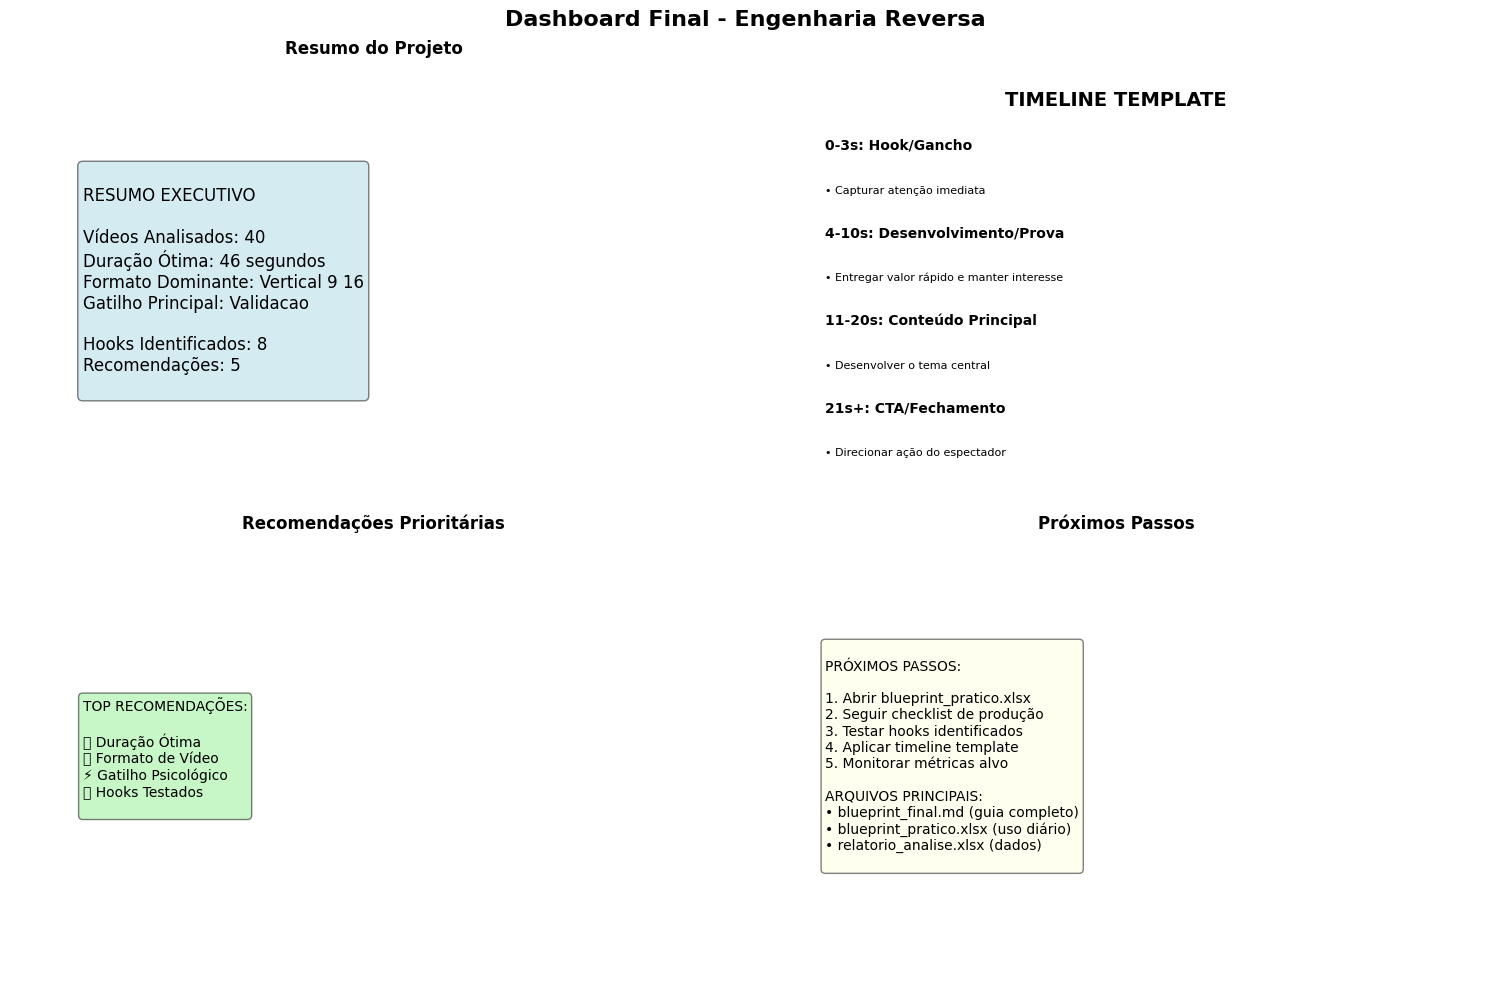

✅ RELATÓRIO EXECUTIVO GERADO!
Dashboard: /content/drive/MyDrive/Videos Dona Done/_engenharia_reversa/relatorios/dashboard_final.png
Relatório JSON: /content/drive/MyDrive/Videos Dona Done/_engenharia_reversa/relatorios/relatorio_executivo_final.json
Relatório MD: /content/drive/MyDrive/Videos Dona Done/_engenharia_reversa/relatorios/relatorio_executivo_final.md

🎉 PROCESSO COMPLETO FINALIZADO!
📁 Pasta de trabalho: /content/drive/MyDrive/Videos Dona Done/_engenharia_reversa
📊 40 vídeos analisados
🎯 8 hooks identificados
📝 5 recomendações geradas

📋 PRÓXIMOS PASSOS:
1. Abrir: /content/drive/MyDrive/Videos Dona Done/_engenharia_reversa/blueprint/blueprint_pratico.xlsx
2. Ler: /content/drive/MyDrive/Videos Dona Done/_engenharia_reversa/blueprint/blueprint_final.md
3. Aplicar blueprint na criação de novos conteúdos
4. Monitorar métricas de performance


In [ ]:
# ============================================================================
# CÉLULA 8: VISUALIZAÇÃO FINAL E RELATÓRIO EXECUTIVO
# ============================================================================

def verificar_conclusao_completa():
    """Verifica se todo o processo foi concluído"""
    try:
        config_path = os.path.join(PASTA_TRABALHO, "config", "config.json")
        with open(config_path, 'r', encoding='utf-8') as f:
            config = json.load(f)

        if not config['status_etapas']['blueprint']:
            raise Exception("Execute a CÉLULA 7 primeiro")

        return True, config
    except Exception as e:
        print(f"❌ PROCESSO INCOMPLETO: {e}")
        return False, None

def gerar_relatorio_executivo_final():
    """Gera relatório executivo final com todos os resultados"""
    # Carregar dados
    config_path = os.path.join(PASTA_TRABALHO, "config", "config.json")
    with open(config_path, 'r', encoding='utf-8') as f:
        config = json.load(f)

    blueprint_path = os.path.join(PASTA_TRABALHO, "blueprint", "blueprint_completo.json")
    with open(blueprint_path, 'r', encoding='utf-8') as f:
        blueprint = json.load(f)

    analise_path = os.path.join(PASTA_TRABALHO, "dados", "analise_padroes.json")
    with open(analise_path, 'r', encoding='utf-8') as f:
        analise = json.load(f)

    # Criar relatório executivo
    relatorio = {
        'projeto_info': {
            'pasta_analisada': PASTA_VIDEOS,
            'pasta_trabalho': PASTA_TRABALHO,
            'processamento_iniciado': config['projeto']['criado_em'],
            'processamento_concluido': datetime.now().isoformat(),
            'versao_sistema': config['projeto']['versao']
        },

        'resultados_numericos': {
            'videos_descobertos': config.get('total_videos_encontrados', 0),
            'videos_processados': config.get('videos_com_metadados', 0),
            'videos_decompostos': config.get('videos_decompostos', 0),
            'total_frames_analisados': analise['resumo_geral']['total_frames_analisados'],
            'total_textos_extraidos': analise['resumo_geral']['total_textos_encontrados'],
            'total_cortes_detectados': analise['resumo_geral']['total_cortes_detectados']
        },

        'insights_principais': {
            'formato_vencedor': blueprint['resumo_executivo']['formato_dominante'],
            'duracao_otima': blueprint['resumo_executivo']['duracao_otima'],
            'gatilho_dominante': blueprint['resumo_executivo']['gatilho_principal'],
            'ritmo_edicao': blueprint['resumo_executivo']['densidade_cortes'],
            'hooks_identificados': len(blueprint['banco_hooks']['hooks_testados']),
            'recomendacoes_geradas': len(blueprint['recomendacoes_prioritarias'])
        },

        'arquivos_gerados': {
            'blueprint_json': 'blueprint/blueprint_completo.json',
            'blueprint_markdown': 'blueprint/blueprint_final.md',
            'blueprint_excel': 'blueprint/blueprint_pratico.xlsx',
            'dados_completos': 'dados/analise_padroes.json',
            'relatorio_excel': 'relatorios/relatorio_analise.xlsx',
            'graficos': 'relatorios/*.png'
        },

        'proximo_passo': {
            'acao_recomendada': 'Implementar blueprint na criação de novos conteúdos',
            'arquivos_chave': ['blueprint_pratico.xlsx', 'blueprint_final.md'],
            'metricas_acompanhar': list(blueprint['metricas_alvo'].keys())
        }
    }

    return relatorio

def criar_dashboard_visual_final():
    """Cria dashboard visual final com principais métricas"""
    # Carregar dados
    blueprint_path = os.path.join(PASTA_TRABALHO, "blueprint", "blueprint_completo.json")
    with open(blueprint_path, 'r', encoding='utf-8') as f:
        blueprint = json.load(f)

    # Criar dashboard
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Dashboard Final - Engenharia Reversa', fontsize=16, fontweight='bold')

    # 1. Resumo numérico
    ax1.axis('off')
    resumo_texto = f"""
RESUMO EXECUTIVO

Vídeos Analisados: {blueprint['metadata']['baseado_em']}
Duração Ótima: {blueprint['resumo_executivo']['duracao_otima']}
Formato Dominante: {blueprint['resumo_executivo']['formato_dominante'].replace('_', ' ').title()}
Gatilho Principal: {blueprint['resumo_executivo']['gatilho_principal'].title()}

Hooks Identificados: {len(blueprint['banco_hooks']['hooks_testados'])}
Recomendações: {len(blueprint['recomendacoes_prioritarias'])}
    """
    ax1.text(0.1, 0.5, resumo_texto, fontsize=12, verticalalignment='center',
             bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue", alpha=0.5))
    ax1.set_title('Resumo do Projeto', fontweight='bold')

    # 2. Timeline visual
    ax2.axis('off')
    timeline = blueprint['timeline_template']
    y_pos = 0.8

    ax2.text(0.5, 0.9, 'TIMELINE TEMPLATE', ha='center', fontweight='bold', fontsize=14)

    for faixa, config in timeline.items():
        ax2.text(0.1, y_pos, f"{faixa}: {config['funcao']}", fontsize=10, fontweight='bold')
        ax2.text(0.1, y_pos-0.1, f"• {config['objetivo']}", fontsize=8)
        y_pos -= 0.2

    ax2.set_xlim(0, 1)
    ax2.set_ylim(0, 1)

    # 3. Top recomendações
    ax3.axis('off')
    recom_texto = "TOP RECOMENDAÇÕES:\n\n"

    for i, recom in enumerate(blueprint['recomendacoes_prioritarias'][:4], 1):
        priority_symbol = "🔥" if recom['prioridade'] == 'alta' else "⚡"
        recom_texto += f"{priority_symbol} {recom['titulo']}\n"

    ax3.text(0.1, 0.5, recom_texto, fontsize=10, verticalalignment='center',
             bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgreen", alpha=0.5))
    ax3.set_title('Recomendações Prioritárias', fontweight='bold')

    # 4. Próximos passos
    ax4.axis('off')
    proximos_passos = """
PRÓXIMOS PASSOS:

1. Abrir blueprint_pratico.xlsx
2. Seguir checklist de produção
3. Testar hooks identificados
4. Aplicar timeline template
5. Monitorar métricas alvo

ARQUIVOS PRINCIPAIS:
• blueprint_final.md (guia completo)
• blueprint_pratico.xlsx (uso diário)
• relatorio_analise.xlsx (dados)
    """

    ax4.text(0.1, 0.5, proximos_passos, fontsize=10, verticalalignment='center',
             bbox=dict(boxstyle="round,pad=0.3", facecolor="lightyellow", alpha=0.5))
    ax4.set_title('Próximos Passos', fontweight='bold')

    plt.tight_layout()

    # Salvar dashboard
    dashboard_path = os.path.join(PASTA_TRABALHO, "relatorios", "dashboard_final.png")
    plt.savefig(dashboard_path, dpi=300, bbox_inches='tight')
    plt.show()

    return dashboard_path

def salvar_relatorio_executivo(relatorio):
    """Salva relatório executivo final"""
    relatorio_path = os.path.join(PASTA_TRABALHO, "relatorios", "relatorio_executivo_final.json")
    with open(relatorio_path, 'w', encoding='utf-8') as f:
        json.dump(relatorio, f, indent=2, ensure_ascii=False)

    # Criar versão markdown do relatório
    md_relatorio = f"""# Relatório Executivo Final - Engenharia Reversa

## Informações do Projeto
- **Pasta Analisada:** {relatorio['projeto_info']['pasta_analisada']}
- **Processamento Iniciado:** {relatorio['projeto_info']['processamento_iniciado']}
- **Processamento Concluído:** {relatorio['projeto_info']['processamento_concluido']}

## Resultados Numéricos
- **Vídeos Descobertos:** {relatorio['resultados_numericos']['videos_descobertos']}
- **Vídeos Processados:** {relatorio['resultados_numericos']['videos_processados']}
- **Frames Analisados:** {relatorio['resultados_numericos']['total_frames_analisados']}
- **Textos Extraídos:** {relatorio['resultados_numericos']['total_textos_extraidos']}

## Insights Principais
- **Formato Vencedor:** {relatorio['insights_principais']['formato_vencedor']}
- **Duração Ótima:** {relatorio['insights_principais']['duracao_otima']}
- **Gatilho Dominante:** {relatorio['insights_principais']['gatilho_dominante']}
- **Hooks Identificados:** {relatorio['insights_principais']['hooks_identificados']}

## Arquivos Gerados
- Blueprint JSON: `{relatorio['arquivos_gerados']['blueprint_json']}`
- Blueprint Markdown: `{relatorio['arquivos_gerados']['blueprint_markdown']}`
- Blueprint Excel: `{relatorio['arquivos_gerados']['blueprint_excel']}`
- Relatório Completo: `{relatorio['arquivos_gerados']['relatorio_excel']}`

## Próximo Passo
**{relatorio['proximo_passo']['acao_recomendada']}**

Arquivos-chave: {', '.join(relatorio['proximo_passo']['arquivos_chave'])}
"""

    md_path = os.path.join(PASTA_TRABALHO, "relatorios", "relatorio_executivo_final.md")
    with open(md_path, 'w', encoding='utf-8') as f:
        f.write(md_relatorio)

    return relatorio_path, md_path

# Executar relatório final
conclusao_ok, config = verificar_conclusao_completa()

if conclusao_ok:
    try:
        print("Gerando relatório executivo final...")

        # Gerar relatório
        relatorio = gerar_relatorio_executivo_final()

        # Criar dashboard visual
        dashboard_path = criar_dashboard_visual_final()

        # Salvar relatórios
        json_rel_path, md_rel_path = salvar_relatorio_executivo(relatorio)

        print("✅ RELATÓRIO EXECUTIVO GERADO!")
        print(f"Dashboard: {dashboard_path}")
        print(f"Relatório JSON: {json_rel_path}")
        print(f"Relatório MD: {md_rel_path}")

        # Resumo final
        print(f"\n🎉 PROCESSO COMPLETO FINALIZADO!")
        print(f"📁 Pasta de trabalho: {PASTA_TRABALHO}")
        print(f"📊 {relatorio['resultados_numericos']['videos_processados']} vídeos analisados")
        print(f"🎯 {relatorio['insights_principais']['hooks_identificados']} hooks identificados")
        print(f"📝 {relatorio['insights_principais']['recomendacoes_geradas']} recomendações geradas")

        print(f"\n📋 PRÓXIMOS PASSOS:")
        print(f"1. Abrir: {PASTA_TRABALHO}/blueprint/blueprint_pratico.xlsx")
        print(f"2. Ler: {PASTA_TRABALHO}/blueprint/blueprint_final.md")
        print(f"3. Aplicar blueprint na criação de novos conteúdos")
        print(f"4. Monitorar métricas de performance")

    except Exception as e:
        print(f"❌ ERRO NO RELATÓRIO FINAL: {e}")
else:
    print("Execute todas as células anteriores antes desta.")
